In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels as sm
import os

## Building a time series ARIMA Model

I decided to use an ARIMA model (Auto Regressed Integrated Moving Averages) to predict NO2 concentration because the Earth's weather patterns are relatively stable and we don't expect drastic change in the near future. Our dataset used NO2 concentration data from the years 2015-2020 (including the effect of COVID). First, I tested the NO2 dataset for stationarity and graphed the autocorrelation. In this case, stationary implies the series is mean-reverting. This means that a stationary time series is one whose statistical properties don't depend on time.

In [4]:
No2 = pd.read_csv("No2 Master Data Covid.csv")
No2["Month"] = pd.to_datetime(No2["Month"])
No2.head()

,Month,No2_con,No2_AQI
0,2015-01-01,26.100,24.372
1,2015-02-01,23.780,22.198
2,2015-03-01,22.808,21.261
3,2015-04-01,18.717,17.421
4,2015-05-01,12.130,11.220


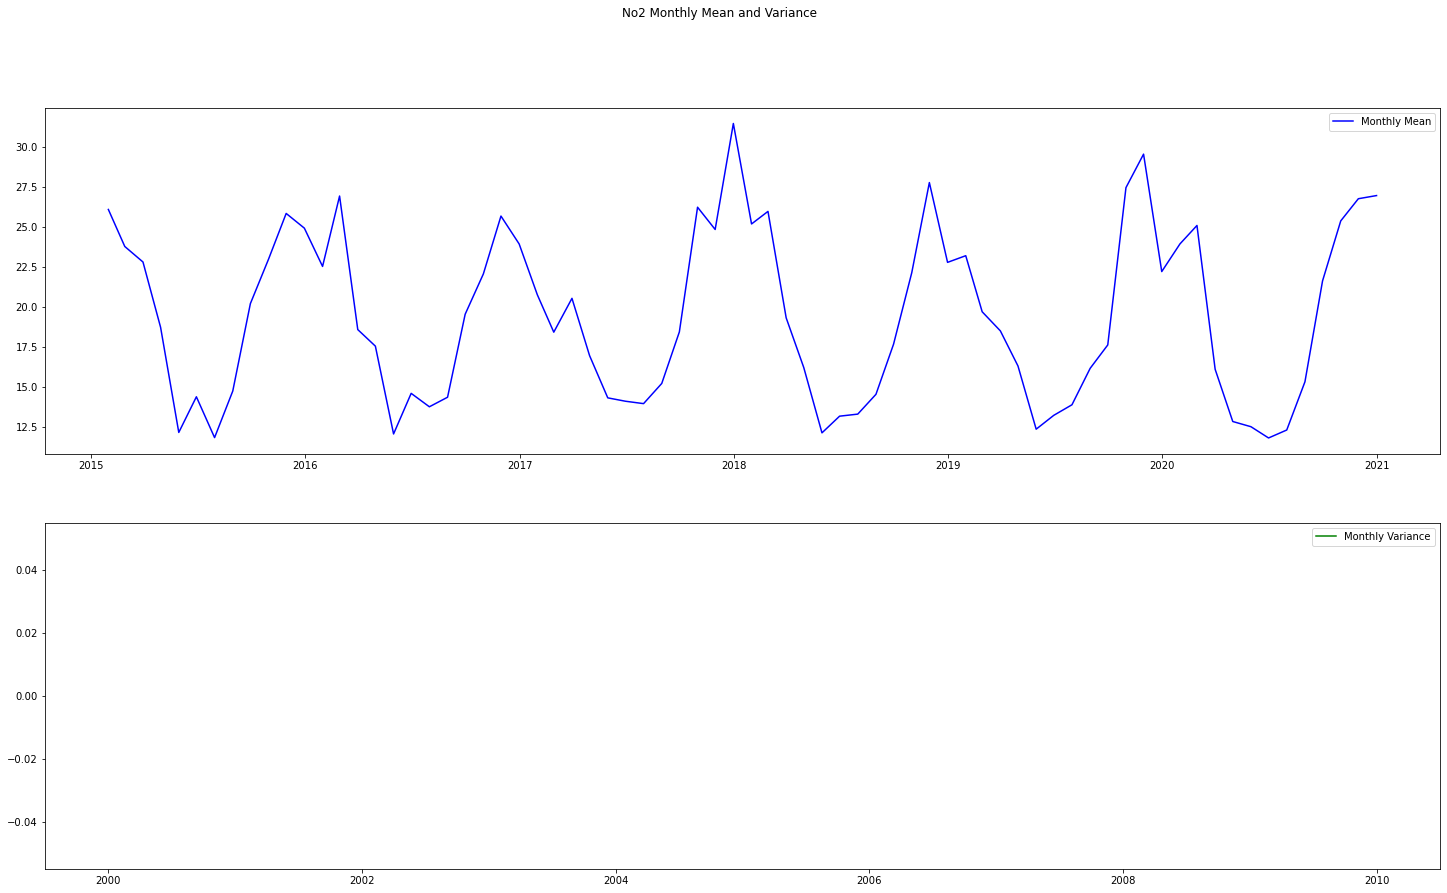

In [5]:
No2_month_mean = No2.groupby(pd.Grouper(key = "Month", freq = "1M")).mean().reset_index()
No2_month_var = No2.groupby(pd.Grouper(key = "Month", freq = "1M")).var().reset_index()
fig,ax = plt.subplots(2,1,figsize = (25,14))
ax[0].plot(No2_month_mean["Month"],No2_month_mean['No2_con'], color = "blue", label = "Monthly Mean")
ax[1].plot(No2_month_var["Month"],No2_month_var['No2_con'], color = "green", label = "Monthly Variance")
fig.suptitle("No2 Monthly Mean and Variance")
ax[0].legend(loc = 'upper right')
ax[1].legend(loc = 'upper right')
plt.show()


As can be inferred from the graphs above, we can see there is no specific trend within the mean or variance of No2_con over time (it is not increasing or decreasing). Therefore, we can infer stationarity. 

Next, I will plot the autocorrelation of the same dataset, which analyzes how correlated a series is with a lagged (past) version of itself. A stationary time series plot will have a constant autocorrelation pattern.

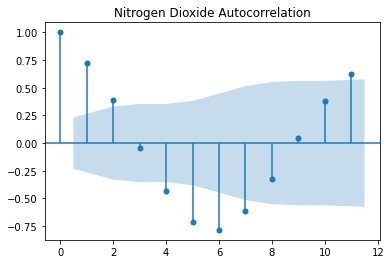

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

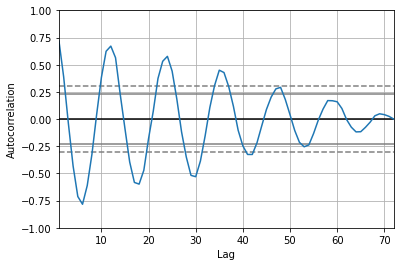

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(No2["No2_con"], lags = 11)
plt.title('Nitrogen Dioxide Autocorrelation')
plt.show()
plt.savefig('NO2 Autocorrelation.png', dpi=300, bbox_inches='tight')
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(No2["No2_con"])

There is a repeating pattern in the autocorrelation graph above about every 12 months, implying a yearly trend and constant pattern. This further provides evidence for stationarity. Next we test the dataset for partial autocorrelation in order to find a p value for the ARIMA model. A partial autocorrelation plot depicts the correlation between two observations that the shorter lags between those observations do not explain.

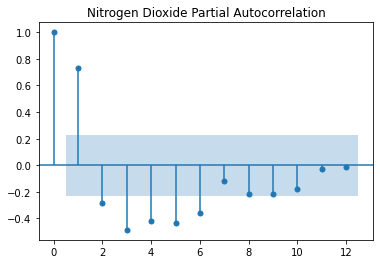

In [11]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(No2["No2_con"], lags = 12)
plt.title('Nitrogen Dioxide Partial Autocorrelation')
plt.show()

Here we see that lags of order 0-1 are highly statistically significant, which will be our p value. We can use this to create our ARIMA model later on. An ARIMA model uses 3 main parameters: p, d, and q values. For the sake of this model, my initial estimations were p=0-1, d=0 (due to the stationarity of the dataset), and q=0 (due to the absence of lag of the error component).

## Train-Test-Split

In [12]:
import sys
!{sys.executable} -m pip install pmdarima

In [18]:
#splitting into test and training data
from pmdarima.arima import auto_arima
arima_df = No2[["No2_con"]]
train_df = arima_df[:58] #80-20 split
test_df = arima_df [-15:]

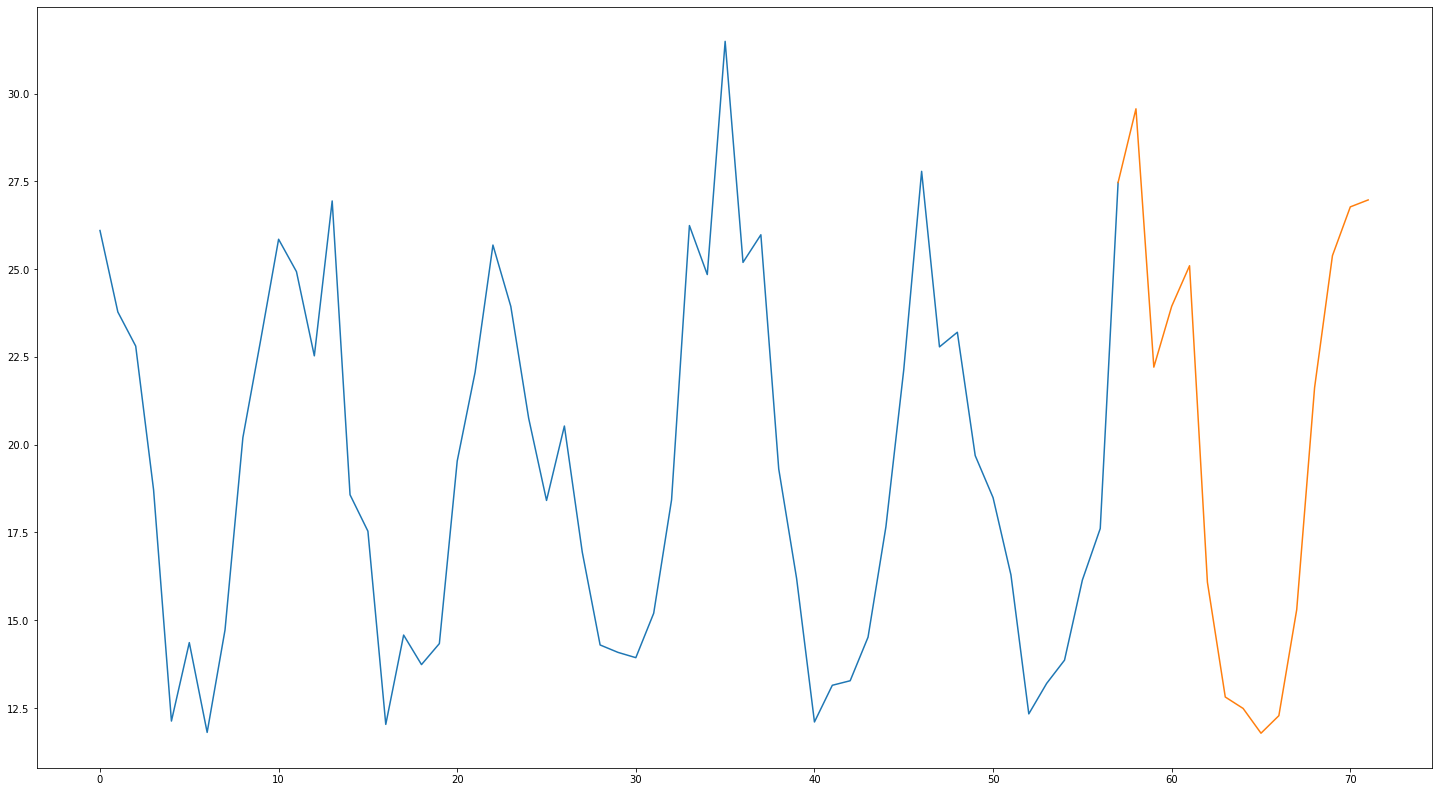

In [19]:
#plotting figure before predictive analysis
fig = plt.figure(figsize = (25,14))
plt.plot(train_df)
plt.plot(test_df)
plt.show()

In [15]:
#finding best ARIMA parameters
auto_arima(train_df, start_p=0,start_q=0,
          max_p=10,max_q=5, stationary=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=356.549, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=317.875, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=333.430, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=513.239, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=317.083, Time=0.13 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=291.104, Time=0.24 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=284.336, Time=0.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=280.767, Time=0.46 sec
 ARIMA(6,0,0)(0,0,0)[0] intercept   : AIC=275.668, Time=0.68 sec
 ARIMA(7,0,0)(0,0,0)[0] intercept   : AIC=277.333, Time=0.81 sec
 ARIMA(6,0,1)(0,0,0)[0] intercept   : AIC=277.556, Time=0.75 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=279.685, Time=0.64 sec
 ARIMA(7,0,1)(0,0,0)[0] intercept   : AIC=279.333, Time=0.81 sec
 ARIMA(6,0,0)(0,0,0)[0]             : AIC=inf, Time=0.24 sec

Best model:  ARIMA(6,0,0)(0,0,0)[0] intercept
Tota

ARIMA(order=(6, 0, 0), scoring_args={}, suppress_warnings=True)

After using the auto_arima function from pmdarima with the initial estimates, I found p=6, d=0,q=0 to be the best values. Next I will build the model using the ARIMA (6,0,0) format

In [30]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_df, order = (6,0,0)) 
model_fit= model.fit()
forecast_month= model_fit.predict(start = 58, end = 72)
forecast_df_month = pd.DataFrame(forecast_month)

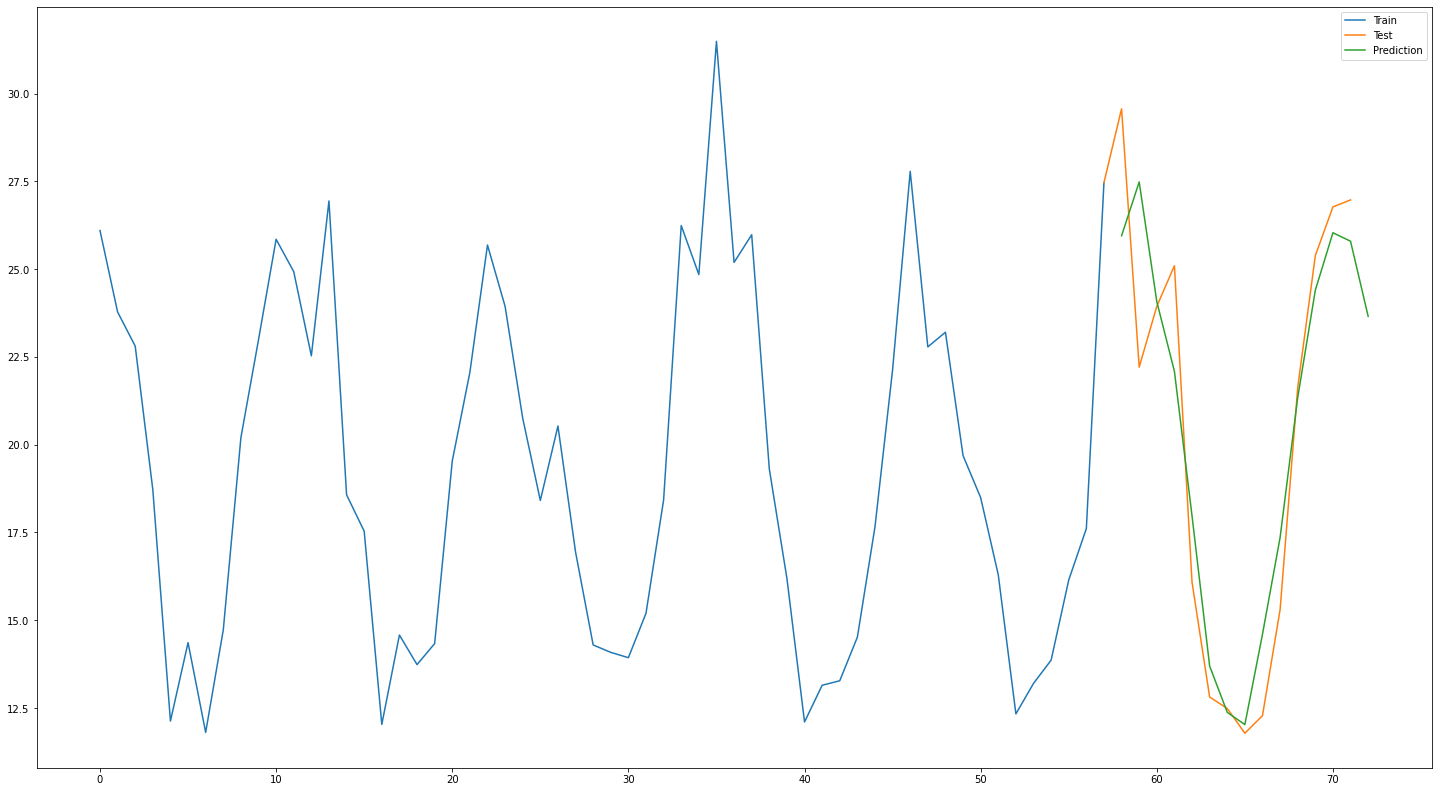

In [23]:
#predictive figure up to the end of 2020
fig = plt.figure(figsize = (25,14))
plt.plot(train_df, label='Train')
plt.plot(test_df, label='Test')
plt.plot(forecast_df_month, label='Prediction')
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt
print(mean_squared_error(forecast_df_month,test_df))
print(r2_score(forecast_df_month,test_df))
print(sqrt(mean_squared_error(test_df,forecast_df_month))) #mse

10.709820312509441
0.6112694225079263
3.272586181066809


The forecasted prediction correlation to the actual test data has an $R^2$ of .6 and a mse of 3.27. These values imply the ARIMA model prediction fits the actual data with reasonable accuracy.

In [29]:
model = ARIMA(train_df, order = (6,0,0)) 
model_fit= model.fit()
forecast_month= model_fit.predict(start = 58, end = 132)
forecast_df_month = pd.DataFrame(forecast_month)

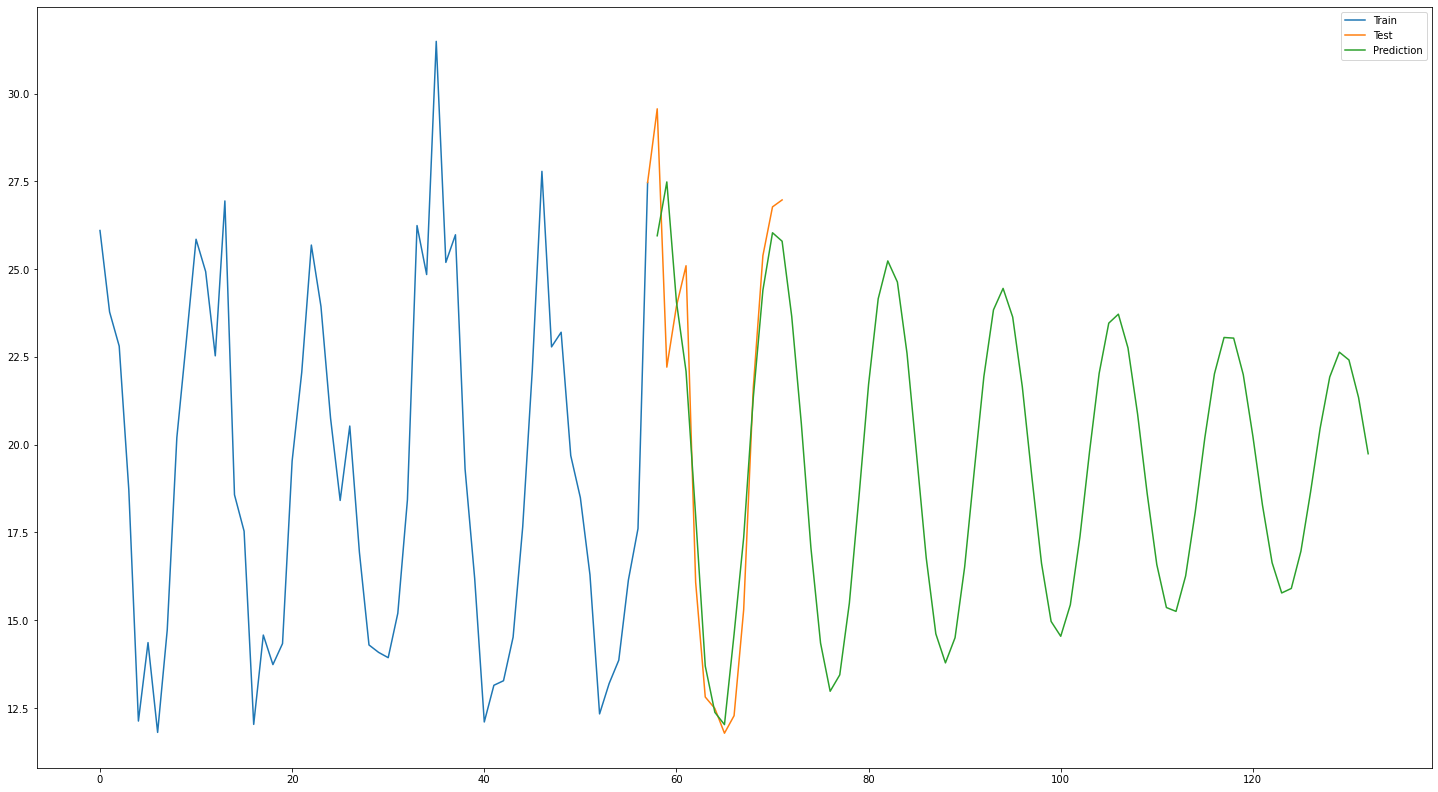

In [28]:
#predictive figure up to the end of 2025
fig = plt.figure(figsize = (25,14))
plt.plot(train_df, label='Train')
plt.plot(test_df, label='Test')
plt.plot(forecast_df_month, label='Prediction')
plt.legend()
plt.show()